In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split

In [2]:
# run this to see what has already been imported
#whos

In [3]:
# pandas doesn't understand ~, so provide full path
base_path = Path('/home/jupyter/mimic')

```python
# run this the first time to covert CSV to Pickle file
df = pd.read_csv(base_path/'NOTEEVENTS.csv', low_memory=False, memory_map=True)
df.to_pickle(base_path/'noteevents.pickle')
```

In [4]:
# this is much faster than reading a csv
df = pd.read_pickle(base_path/'noteevents.pickle')

In [5]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [6]:
df.dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

In [7]:
df.shape

(2083180, 11)

In [8]:
# split data into train and test sets
seed = 42
test_size = 0.333333333
train, test = train_test_split(df, test_size=test_size, random_state=seed)

In [9]:
train.shape

(1388786, 11)

In [10]:
test.shape

(694394, 11)

In [11]:
#data = TextClasDataBunch.from_df(base_path, train_df = train, valid_df = test, text_cols='TEXT')
#data.show_batch()

data = (TextList.from_df(df, 'texts.csv', cols='TEXT')
                .split_by_rand_pct(valid_pct=0.2, seed=seed) 
                .label_from_df(cols='CATEGORY')
                .databunch())

In [12]:
bs=48

filename = base_path/'mimic_lm.pickle'

if os.path.isfile(filename):
    data_lm = load_data(base_path, 'mimic_lm.pickle', bs=bs)
else:
    data_lm = (TextList.from_df(df, 'texts.csv', cols='TEXT')
               #We may have other temp folders that contain text files so we only keep what's in train and test
               .split_by_rand_pct(0.1)
               #We randomly split and keep 10% for validation
               .label_for_lm()
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    data_lm.save(base_path/'mimic_lm.pickle')

FileNotFoundError: [Errno 2] No such file or directory: 'texts.csv/mimic_lm.pickle'

In [15]:
# data_lm.save(base_path/'mimic_lm.pickle')

In [ ]:
## why does this only seem to use CPU?
# both textclasdatabunch and textlist...
# run out of memory at 32 GB, error at 52 GB, trying 72GB now... got down to only 440MB free; if crash again, increase memory
# now at 20vCPU and 128GB RAM; ok up to 93%; got down to 22GB available
# try smaller batch size?

In [12]:
bs=48
data_lm = load_data(base_path, 'mimic_lm.pickle', bs=bs)

In [13]:
# see https://docs.fast.ai/text.transform.html#Tokenizer for details on what various artificial tokens (e.g xxup, xxmaj, etc.) mean
data_lm.show_batch()

idx,text
0,"xxup of xxup present xxup illness : xxmaj this is an 81-year - old female \n with a history of emphysema ( not on home xxup o2 ) , who presents \n with three days of shortness of breath thought by her primary \n care doctor to be a xxup copd flare . xxmaj two days prior to admission , \n she was started on a"
1,"and the benefits , especially xxunk \n of being paralyzed were discussed , and the xxunk to \n proceed . xxmaj posterior cervical laminectomy , xxup c4 , xxup c5 , xxup c6 , resection \n of extramedullary intradural spinal cord tumor was performed . \n xxmaj surgery was successful without significant complications . \n xxmaj patient was started on decadron on admission and it"
2,"* * ] : xxup ekg showed xxup nsr @ 87 with xxup std in i , avl and xxup v6 with \n 1 mm xxup std in xxup v3-v6 . \n \n [ * * 2119 - 1 - 16 * * ] xxup tte : \n xxmaj the left atrium is dilated . xxmaj there is mild regional left \n ventricular systolic dysfunction with"
3,xxup 10:00am xxup blood xxmaj albumin-3.1 * xxmaj calcium-10.0 xxmaj phos-2.3 * \n xxmaj mg-1.4 * \n [ * * 2199 - 4 - 29 * * ] xxup 10:00am xxup blood xxup xxunk * \n \n xxmaj brief xxmaj hospital xxmaj course : \n 1 . xxup gi bleeding- xxmaj pt with melanotic stools and a xxmaj hct drop from 32 \n on [
4,xxmaj dextrose 50 % 50 ml xxup prn hypoglycemia \n - xxmaj diazepam 5 mg xxup po xxup qhs xxup prn for sleep \n - xxmaj glucagon 1 mg xxup im xxup prn hypoglycemia \n - xxmaj glucose chewable 4 g tab xxup prn \n - xxmaj lidocaine 2 % viscous solution xxup q6h xxup prn pain \n - xxmaj xxunk xxmaj plus xxmaj susp


In [23]:
# default 20
pd.get_option('display.max_columns')
pd.set_option('display.max_columns', 20)
# default 50
pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)

In [33]:
# how to look at original version of text
#df[df['TEXT'].str.contains('being paralyzed were discussed', case=False)].TEXT

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


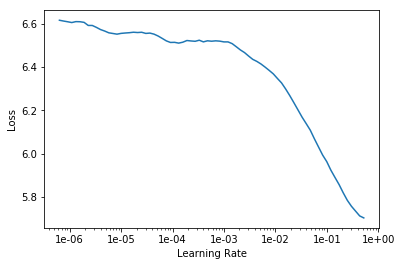

In [34]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [35]:
# no idea how long nor how much resources this will take
# not sure 1e-2 is the right learning rate; maybe 1e-1 or between 1e-2 and 1e-1
# progress bar says this will take around 24 hours... ran for about 52 minutes
# gpustat/nvidia-smi indicates currently only using about 5GB of GPU RAM
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 